In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

In [14]:
#load prepared data
train_set=pd.read_csv('train_set_new.csv')
val_set=pd.read_csv('val_set_new.csv')
test_set=pd.read_csv('test_set_new.csv')

In [7]:
#set date as an index
train_set = train_set.set_index('Date')
val_set = val_set.set_index('Date')
test_set = test_set.set_index('Date')

print(train_set.shape, val_set.shape, test_set.shape)

train_set.head()

(359432, 17) (62138, 17) (115064, 17)


,Store,Dept,Unemployment,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Week,Year,Weekly_Sales
Date,,,,,,,,,,,,,,,,,
2010-02-05,1,1,8.106,0,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,5,2010,24924.50
2010-02-12,1,1,8.106,1,1,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,6,2010,46039.49
2010-02-19,1,1,8.106,0,1,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,7,2010,41595.55
2010-02-26,1,1,8.106,0,1,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8,2010,19403.54
2010-03-05,1,1,8.106,0,1,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,9,2010,21827.90


In [8]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset

scaler = MinMaxScaler().fit(train_set)
scaled_train_set = scaler.transform(train_set)

scaled_val_set = scaler.transform(val_set)

scaled_test_set = scaler.transform(test_set)
print(scaled_train_set.shape, scaled_val_set.shape,scaled_test_set.shape)

[[1.000000e+00 1.000000e+00 8.106000e+00 ... 5.000000e+00 2.010000e+03
  2.492450e+04]
 [1.000000e+00 1.000000e+00 8.106000e+00 ... 6.000000e+00 2.010000e+03
  4.603949e+04]
 [1.000000e+00 1.000000e+00 8.106000e+00 ... 7.000000e+00 2.010000e+03
  4.159555e+04]
 ...
 [4.500000e+01 9.800000e+01 8.567000e+00 ... 2.000000e+01 2.012000e+03
  7.454400e+02]
 [4.500000e+01 9.800000e+01 8.567000e+00 ... 2.100000e+01 2.012000e+03
  7.959400e+02]
 [4.500000e+01 9.800000e+01 8.567000e+00 ... 2.200000e+01 2.012000e+03
  8.746400e+02]]
----------------
            Store  Dept  Unemployment  IsHoliday  Type    Size  Temperature  \
Date                                                                          
2010-02-05      1     1         8.106          0     1  151315        42.31   
2010-02-12      1     1         8.106          1     1  151315        38.51   
2010-02-19      1     1         8.106          0     1  151315        39.93   
2010-02-26      1     1         8.106          0     1  1513

In [9]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#Here the n_features is 16. We will make timesteps = 12 (past weeks data used for training). 

n_future =1
n_past =12


#Reformat train data into a shape: (n_samples x timesteps x n_features)

train_x =[]
train_y = []

for i in range(n_past, len(scaled_train_set) - n_future+1):
    train_x.append(scaled_train_set[i-n_past:i, 0:scaled_train_set.shape[1]-1])
    train_y.append(scaled_train_set[i+n_future-1:i+n_future,scaled_train_set.shape[1]-1])
    

train_x, train_y = np.array(train_x), np.array(train_y)

print(train_x.shape, train_y.shape)

#Reformat validation data into a shape: (n_samples x timesteps x n_features)

val_x =[] 
val_y = []
for i in range(n_past, len(scaled_val_set) - n_future+1):
    val_x.append(scaled_val_set[i-n_past:i, 0:scaled_val_set.shape[1]-1]) 
    val_y.append(scaled_val_set[i+n_future-1:i+n_future, scaled_val_set.shape[1]-1])
    

val_x, val_y = np.array(val_x), np.array(val_y)
print(val_x.shape, val_y.shape)

(359420, 12, 16) (359420, 1)
(62126, 12, 16) (62126, 1)


In [10]:
# define the model 
lstm_model = keras.Sequential()
lstm_model.add(LSTM(64, activation='relu',input_shape=(train_x.shape[1],train_x.shape[2]), return_sequences=True))
lstm_model.add(Dropout(0.4))
lstm_model.add(LSTM(32, activation='relu', return_sequences=False))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(train_y.shape[1]))
lstm_model.compile(optimizer='adam', loss='mse',metrics=['mse',"mean_absolute_percentage_error"])
lstm_model.summary()

# fit the model
history =lstm_model.fit(train_x, train_y,validation_split=0.1, epochs=50, verbose=1)


train_loss = lstm_model.evaluate(train_x, train_y, verbose=1)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 64)            20736     
_________________________________________________________________
dropout (Dropout)            (None, 12, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 33,185
Trainable params: 33,185
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
10109/10109 [==============================] - 136s 13ms/step - loss: 8.6959e-04 - mse: 8.6959e-04 - mean_a

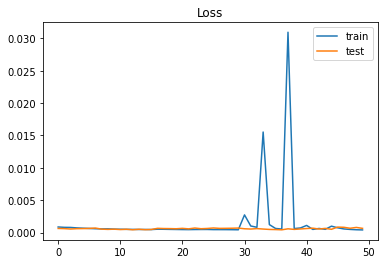

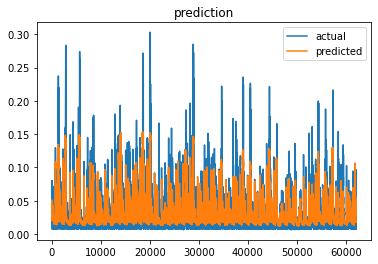

In [11]:
# plot loss during training
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

y_val_pred = lstm_model.predict(val_x)

plt.title('prediction')
plt.plot(val_y, label='actual')
plt.plot(y_val_pred, label='predicted')
plt.legend()
plt.show()


In [12]:
# inverse transform the dataset to operate on the original values size
scaled_val_set_1 = scaler.transform(val_set)
scaled_val_set_2= scaler.inverse_transform(scaled_val_set_1)
scaled_val_set_1[12:len(y_val_pred)+12,-1]=y_val_pred.T
scaled_val_set_3= scaler.inverse_transform(scaled_val_set_1[12:len(y_val_pred)+12,:])


print(scaled_val_set_3.shape)

(62126, 17)


In [15]:
#save calculated and original sales in one table
y_pred_date=pd.DataFrame()
y_pred_date['Date']=val_set[n_past:len(val_set)].Date
y_pred_date['Store']=val_set[n_past:len(val_set)].Store
y_pred_date['Weekly_Sales']=val_set[n_past:len(val_set)].Weekly_Sales
y_pred_date.reset_index(drop=True, inplace=True)
y_pred_date['Prediction']=scaled_val_set_3[:,-1]
y_pred_date.to_csv('prediction_all.csv', sep=',' , index= True)
y_pred_date


,Date,Store,Weekly_Sales,Prediction
0,2012-08-31,1,16680.24,14985.473004
1,2012-09-07,1,18322.37,14935.831803
2,2012-09-14,1,19616.22,14889.696185
3,2012-09-21,1,19251.50,13793.928137
4,2012-09-28,1,18947.81,17459.378947
...,...,...,...,...
62121,2012-09-28,45,508.37,7183.176966
62122,2012-10-05,45,628.10,7094.506237
62123,2012-10-12,45,1061.02,7022.428518
62124,2012-10-19,45,760.01,6995.814166


In [ ]:
#group the date per store per date
""" y_pred_date=y_pred_date.groupby(['Store', 'Date']).sum()
y_pred_date.to_csv('prediction_all.csv', sep=',' , index= True)
y_pred_date """

Weekly_Sales    Prediction
Store Date                                  
1     2012-03-02    1668307.73  1.300074e+06
      2012-03-09    1654291.09  1.300061e+06
      2012-03-16    1655105.90  1.334528e+06
      2012-03-23    1488960.37  1.350412e+06
      2012-03-30    1620651.77  1.344402e+06
...                        ...           ...
45    2012-09-28     713173.95  9.302084e+05
      2012-10-05     733455.07  9.271829e+05
      2012-10-12     734464.36  8.919298e+05
      2012-10-19     718125.53  9.090475e+05
      2012-10-26     760281.43  9.093570e+05

[1575 rows x 2 columns]